## Behavioural Finance with ML

This Notebook illustrates some of the work being done at the intersection of behavioral finance and machine learning.

The analysis in the notebook draws insperation from:

Man versus Machine Learning: The Term Structure of Earnings Expectations and Conditional Biases. van Binsbergen, J. H., Han, X., & Lopez-Lira, A. (2023). The Review of Financial Studies, 36(5), 1801-1842.

We introduce a real-time measure of conditional biases to firms’ earnings forecasts. The measure is defined as the difference between analysts’ expectations and a statistically optimal unbiased machine-learning benchmark. Analysts’ conditional expectations are, on average, biased upward, a bias that increases in the forecast horizon. These biases are associated with negative cross-sectional return predictability, and the short legs of many anomalies contain firms with excessively optimistic earnings forecasts. Further, managers of companies with the greatest upward-biased earnings forecasts are more likely to issue stocks. Commonly used linear earnings models do not work out-of-sample and are inferior to those analysts provide.


Machine Forecast Disagreement. Working Paper 

We propose a statistical model of heterogeneous beliefs where investors are represented as different machine learning model specifications. Investors form return forecasts from their individual models using common data inputs. We measure disagreement as forecast dispersion across investor-models (MFD). Our measure aligns with analyst forecast disagreement but more powerfully predicts returns. We document a large and robust association between belief disagreement and future returns. A decile spread portfolio that sells stocks with high disagreement and buys stocks with low disagreement earns a value-weighted return of 14% per year. Further analyses suggest MFD-alpha is mispricing induced by short-sale costs and limits-to-arbitrage.

#### Import necessary libraries

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import ssl
import warnings

from tqdm import tqdm
from joblib import Parallel, delayed
import statsmodels.api as sm

In [18]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Setting seeds for reproducibility
np.random.seed(0)
random.seed(0)

# Fix SSL certificate issue for downloading data
ssl._create_default_https_context = ssl._create_stdlib_context

#### Load data

We will use the FRED-MD dataset and the AAII investor sentiment survey

In [19]:
def load_fred_md_data(fred_path):
    """
    Function to load data from FRED-MD.

    Args:
        fred_path (str): URL to fetch the dataset from FRED.

    Returns:
        DataFrame: Loaded dataset with transformed series.
        Series: Transformation codes for each series.
    """
    print("Loading data from FRED (this may take a minute)...")
    df = pd.read_csv(fred_path)[:-3]
    print("Done loading data")

    tcodes = df.iloc[0, 1:]  # transformation codes
    df.drop(0, inplace=True)  # Drop unnecessary row

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

    return df, tcodes

In [20]:
def load_aaii_sentiment_data(url=None):
    """
    Load and process AAII sentiment survey data.

    Args:
        url (str): Path to the sentiment data file.

    Returns:
        DataFrame: Processed monthly sentiment data.
    """
    # Load actual data from file
    df = pd.read_excel(url, skiprows=3)

    # Standardize column names
    df.columns = [col.strip().lower() for col in df.columns]
    df = df.rename(columns={
        'bullish': 'bullish_pct',
        'neutral': 'neutral_pct',
        'bearish': 'bearish_pct',
        'date': 'week_ending'
    })

    df = df[:1974]  # Limit rows as in the original code

    # Convert date to datetime
    df['week_ending'] = pd.to_datetime(df['week_ending'])

    # Drop rows with missing values
    df = df.dropna(subset=['bullish_pct', 'bearish_pct'])

    # Compute cross-sectional variance-based disagreement
    mean_sent = (df['bullish_pct'] + df['bearish_pct']) / 2
    # df['disagreement'] = 0.5 * ((df['bullish_pct'] - mean_sent)**2 + (df['bearish_pct'] - mean_sent)**2)
    df['disagreement'] = (1 - (df['bullish_pct'] - df['bearish_pct']))**2

    # Sort by date
    df = df.sort_values('week_ending')

    # Add 'month' column and get last observation per month
    df['month'] = df['week_ending'].dt.to_period('M')
    monthly = df.groupby('month').last()

    # Set index to the first day of each month
    monthly.index = monthly.index.to_timestamp(how='start')

    # Create sentiment indicator
    monthly['sentiment'] = monthly['bullish_pct'] / (monthly['bullish_pct'] + monthly['bearish_pct'])

    # Keep the necessary columns
    monthly_data = monthly[['bullish_pct', 'neutral_pct', 'bearish_pct', 'disagreement', 'sentiment']]

    return monthly_data

Transform the FRED-MD dataset

In [21]:
def transform_series(x, tcode):
    """
    Transform a series according to a transformation code.

    Args:
        x (array): Series to be transformed
        tcode (int): Transformation code (1-7)

    Returns:
        array: Transformed series
    """
    # Number of observations
    n = x.size

    # Value close to zero
    small = 1e-6

    # Allocate output variables
    y = np.nan * np.ones(n)
    y1 = np.nan * np.ones(n)

    # Initialize result
    result = np.nan * np.ones(n)

    # Apply transformation based on code
    if tcode == 1:  # No transformation: x(t)
        result = x

    elif tcode == 2:  # First difference: x(t) - x(t-1)
        y[1:] = x[1:] - x[:-1]
        result = y

    elif tcode == 3:  # Second difference: (x(t) - x(t-1)) - (x(t-1) - x(t-2))
        y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
        result = y

    elif tcode == 4:  # Natural log: ln(x)
        if np.min(x) < small:
            result = np.nan
        else:
            result = np.log(x)

    elif tcode == 5:  # First difference of natural log: ln(x) - ln(x-1)
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[1:] = log_x[1:] - log_x[:-1]
            result = y

    elif tcode == 6:  # Second difference of natural log
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[2:] = log_x[2:] - 2 * log_x[1:-1] + log_x[:-2]
            result = y

    elif tcode == 7:  # First difference of percent change
        y1[1:] = (x[1:] - x[:-1]) / x[:-1]
        y[2:] = y1[2:] - y1[1:-1]
        result = y

    return result

Create the target and predictor variable arrays

In [22]:
def preprocess_data(df):
    """
    Preprocess the data by creating the target variable and handling missing values.

    Args:
        df (DataFrame): Data containing the series.

    Returns:
        DataFrame: Processed data with target variable.
        DataFrame: Full data including VIX for analysis.
    """
    # Define the target as the S&P 500 led by one period
    df['Target'] = df['S&P 500'].shift(periods=-1)

    # Create a copy of the full data, including VIX for analysis
    full_data = df.copy()

    # Drop S&P 500 from predictors but keep VIXCLSx for later analysis
    if 'S&P 500' in df.columns:
        df.drop(['S&P 500'], axis=1, inplace=True)

    # Fill missing values with rolling mean
    df = df.apply(lambda x: x.fillna(x.rolling(window=6, min_periods=1).mean()))
    full_data = full_data.apply(lambda x: x.fillna(x.rolling(window=6, min_periods=1).mean()))

    # Drop any remaining rows with missing values
    df.dropna(inplace=True)
    full_data.dropna(inplace=True)

    return df, full_data

#### Create the ML model that replicates investor behaviour

Our ML model followings the model specified in the Machine Forecast Disagreement paper

In [23]:
class MFDGenerator:
    """
    Class to generate Machine Forecast Disagreement (MFD) for FRED-MD data.
    """

    def __init__(self,
                 num_investors=100,
                 subset_proportion=0.5,
                 max_depth=3,
                 n_estimators=2000,
                 feature_fraction=0.05,
                 sample_fraction=0.05,
                 n_jobs=16):
        """
        Initialize MFD Generator for FRED-MD data.

        Args:
            num_investors (int): Number of simulated investors (K)
            subset_proportion (float): Proportion of features each investor uses
            max_depth (int): Maximum depth of trees in random forest
            n_estimators (int): Number of trees in random forest
            feature_fraction (float): Fraction of features to consider at each split
            sample_fraction (float): Fraction of samples to use for each tree
            n_jobs (int): Number of parallel jobs to run
        """
        self.K = num_investors
        self.subset_proportion = subset_proportion
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.feature_fraction = feature_fraction
        self.sample_fraction = sample_fraction
        self.n_jobs = n_jobs
        self.investors = {}  # Changed to dict for easier parallel results handling
        self.investor_feature_subsets = []

    def _generate_investor_models(self, n_features):
        """
        Generate different random forest models for each investor with random feature subsets.

        Args:
            n_features (int): Total number of available features
        """
        self.investors = {}
        self.investor_feature_subsets = []

        # Calculate subset size
        subset_size = max(int(n_features * self.subset_proportion), 1)

        # Create K different investors with different feature subsets
        for k in range(self.K):
            # Randomly sample features for this investor
            feature_indices = random.sample(range(n_features), subset_size)
            self.investor_feature_subsets.append(feature_indices)

        # No models are trained here - just preparation
        print(f"Created {self.K} investor feature subsets, each with {subset_size} features")

    def generate_forecasts(self, data, initial_window_size, refit_period=12):
        """
        Generate forecasts using the MFD approach with expanding window.

        Args:
            data (DataFrame): Preprocessed data with features and target
            initial_window_size (int): Size of initial training window
            refit_period (int): Number of periods between refits

        Returns:
            dict: Forecasts for each time period and investor
            Series: MFD values for each time period
            Series: Mean investor forecasts for each time period
        """
        # Extract features and target
        X = data.drop('Target', axis=1)
        y = data['Target']

        n_features = X.shape[1]

        # Generate investor models
        self._generate_investor_models(n_features)

        # Initialize storage for forecasts and MFD
        all_forecasts = {}
        mfd_values = {}
        mean_forecasts = {}

        # Track refit counter
        months_since_refit = 0

        # Rolling window approach
        for t in tqdm(range(initial_window_size, len(data) - 1), desc="Generating forecasts"):
            # Get training data up to time t
            train_data = data.iloc[t-initial_window_size:t].copy()

            # Get test data at time t+1
            test_data = data.iloc[t:t + 1].copy()

            # Skip if there are NaN values
            if train_data.isnull().values.any() or test_data.isnull().values.any():
                continue

            # Standardize data
            scaler = StandardScaler()
            train_data_scaled = pd.DataFrame(
                scaler.fit_transform(train_data),
                index=train_data.index,
                columns=train_data.columns
            )
            test_data_scaled = pd.DataFrame(
                scaler.transform(test_data),
                index=test_data.index,
                columns=test_data.columns
            )

            # Check if we need to refit (at the beginning and every refit_period after)
            if months_since_refit == 0:
                # Prepare data for parallel processing
                X_train = train_data_scaled.drop('Target', axis=1)

                # Winsorize returns at 1% in each tail during fitting
                y_train = train_data_scaled['Target'].clip(
                    lower=train_data_scaled['Target'].quantile(0.01),
                    upper=train_data_scaled['Target'].quantile(0.99)
                )

                # Train models in parallel
                results = Parallel(n_jobs=self.n_jobs)(
                    delayed(train_investor_model)(
                        k,
                        self.investor_feature_subsets[k],
                        X_train,
                        y_train,
                        self.max_depth,
                        self.n_estimators,
                        self.feature_fraction,
                        self.sample_fraction
                    ) for k in range(self.K)
                )

                # Update investor models
                for k, model in results:
                    self.investors[k] = model

            # Generate forecasts in parallel
            X_test = test_data_scaled.drop('Target', axis=1)
            forecast_results = Parallel(n_jobs=self.n_jobs)(
                delayed(generate_investor_forecast)(
                    k,
                    self.investors[k],
                    self.investor_feature_subsets[k],
                    X_test
                ) for k in range(self.K)
            )

            # Process forecast results
            test_date = test_data.index[0]
            all_forecasts[test_date] = []

            # Sort results by investor index to ensure consistency
            forecast_results.sort(key=lambda x: x[0])
            for _, forecast in forecast_results:
                all_forecasts[test_date].append(forecast)

            # Calculate MFD as standard deviation of forecasts across investors
            mfd = np.std(all_forecasts[test_date])
            mfd_values[test_date] = mfd

            # Calculate mean forecast across investors
            mean_forecast = np.mean(all_forecasts[test_date])
            mean_forecasts[test_date] = mean_forecast

            # Update refit counter
            months_since_refit = (months_since_refit + 1) % refit_period

        return all_forecasts, pd.Series(mfd_values), pd.Series(mean_forecasts)
    
    def evaluate_mfd_and_returns(self, mfd_values, data, full_data, initial_window_size):
        """
        Analyze relationship between MFD, returns, and VIX (market volatility).

        Args:
            mfd_values (Series): MFD values for each time period
            data (DataFrame): Original data with target
            full_data (DataFrame): Full data including VIX
            initial_window_size (int): Size of initial training window

        Returns:
            DataFrame: Analysis results including MFD, returns, and VIX
        """
        # Convert MFD to DataFrame
        mfd_df = pd.DataFrame({'MFD': mfd_values})

        # Add actual returns
        returns = data['Target'].iloc[initial_window_size + 1:]
        common_index = mfd_df.index.intersection(returns.index)
        mfd_df = mfd_df.loc[common_index]
        returns = returns.loc[common_index]
        mfd_df['Actual_Return'] = returns

        # Add VIX data (if available)
        if 'VIXCLSx' in full_data.columns:
            vix = full_data['VIXCLSx'].loc[common_index]
            mfd_df['VIX'] = vix

            # Calculate correlation between MFD and VIX
            mfd_vix_corr = mfd_df['MFD'].corr(mfd_df['VIX'])
            print(f"\n--- MFD and VIX Analysis ---")
            print(f"Correlation between MFD and VIX: {mfd_vix_corr:.4f}")

            # Run regression to see if MFD explains VIX
            X = sm.add_constant(mfd_df['MFD'])
            model = sm.OLS(mfd_df['VIX'], X).fit()
            print("\nRegression Results (MFD explaining VIX):")
            print(f"R-squared: {model.rsquared:.4f}")
            print(
                f"Coefficient: {model.params[1]:.4f} (t-stat: {model.tvalues[1]:.4f}, p-value: {model.pvalues[1]:.4f})")

            # Create lagged variables to test Granger causality
            mfd_df['MFD_lag1'] = mfd_df['MFD'].shift(1)
            mfd_df['VIX_lag1'] = mfd_df['VIX'].shift(1)
            mfd_df.dropna(inplace=True)

            # Test if MFD predicts VIX even controlling for lagged VIX
            X_granger = sm.add_constant(mfd_df[['VIX_lag1', 'MFD']])
            granger_model = sm.OLS(mfd_df['VIX'], X_granger).fit()
            print("\nGranger Causality Test (Does MFD predict VIX?):")
            print(
                f"MFD coefficient: {granger_model.params[2]:.4f} (t-stat: {granger_model.tvalues[2]:.4f}, p-value: {granger_model.pvalues[2]:.4f})")

            # Test if VIX predicts MFD even controlling for lagged MFD
            X_reverse = sm.add_constant(mfd_df[['MFD_lag1', 'VIX_lag1']])
            reverse_model = sm.OLS(mfd_df['MFD'], X_reverse).fit()
            print("\nReverse Causality Test (Does VIX predict MFD?):")
            print(
                f"VIX coefficient: {reverse_model.params[2]:.4f} (t-stat: {reverse_model.tvalues[2]:.4f}, p-value: {reverse_model.pvalues[2]:.4f})")

            # Calculate return correlation for comparison
            return_corr = mfd_df['MFD'].corr(mfd_df['Actual_Return'])
            print(f"\nCorrelation between MFD and future returns: {return_corr:.4f}")
        else:
            print("VIX data not available in the dataset")

        # Sort by MFD and create deciles for return analysis
        mfd_df['MFD_Decile'] = pd.qcut(mfd_df['MFD'], 10, labels=False)

        # Calculate average return by decile
        decile_returns = mfd_df.groupby('MFD_Decile')['Actual_Return'].mean()

        # Calculate return spread (high MFD minus low MFD)
        high_minus_low = decile_returns.iloc[-1] - decile_returns.iloc[0]
        print(f"Return spread (High MFD - Low MFD): {high_minus_low:.4f}")

        return mfd_df, decile_returns
    
    def compare_with_aaii_sentiment(self, mfd_values, mean_forecasts, sentiment_data, data, initial_window_size):
        """
        Compare MFD with AAII sentiment survey disagreement.

        Args:
            mfd_values (Series): MFD values for each time period
            mean_forecasts (Series): Mean investor forecasts for each time period
            sentiment_data (DataFrame): AAII sentiment survey data
            data (DataFrame): Original data with target
            initial_window_size (int): Size of initial training window

        Returns:
            DataFrame: Analysis results
        """
        # Convert MFD to DataFrame
        mfd_df = pd.DataFrame({
            'MFD': mfd_values,
            'Mean_RF_Forecast': mean_forecasts
        })

        # Add actual returns
        returns = data['Target'].iloc[initial_window_size + 1:]
        common_index = mfd_df.index.intersection(returns.index)
        mfd_df = mfd_df.loc[common_index]
        returns = returns.loc[common_index]
        mfd_df['Actual_Return'] = returns

        # Merge with AAII sentiment data
        # First, make sure AAII data index is a datetime
        sentiment_data.index = pd.to_datetime(sentiment_data.index)

        # Identify the common time period
        common_period_start = max(mfd_df.index.min(), sentiment_data.index.min())
        common_period_end = min(mfd_df.index.max(), sentiment_data.index.max())

        # Filter data to common period
        mfd_filtered = mfd_df.loc[(mfd_df.index >= common_period_start) & (mfd_df.index <= common_period_end)]
        aaii_filtered = sentiment_data.loc[
            (sentiment_data.index >= common_period_start) & (sentiment_data.index <= common_period_end)]

        # Convert both to same frequency (monthly) and align dates
        mfd_monthly = mfd_filtered.resample('MS').first()  # MS = Month Start
        aaii_monthly = aaii_filtered

        # Merge the datasets
        merged_data = pd.merge(mfd_monthly, aaii_monthly, left_index=True, right_index=True, how='inner')

        # Print data coverage
        print(f"\n--- Data Coverage Analysis ---")
        print(f"MFD data period: {mfd_df.index.min()} to {mfd_df.index.max()}")
        print(f"AAII data period: {sentiment_data.index.min()} to {sentiment_data.index.max()}")
        print(f"Common period: {common_period_start} to {common_period_end}")
        print(f"Number of common months: {len(merged_data)}")

        print("\n--- Correlation Analysis ---")
        # Calculate correlation between MFD and AAII disagreement
        mfd_aaii_corr = merged_data['MFD'].corr(merged_data['disagreement'])
        print(f"Correlation between MFD and AAII disagreement: {mfd_aaii_corr:.4f}")

        # Compare predictive power for returns
        print("\n--- Predictive Power Analysis ---")

        # 1. MFD-based prediction (mean RF forecast)
        X_rf = sm.add_constant(merged_data['Mean_RF_Forecast'])
        model_rf = sm.OLS(merged_data['Actual_Return'], X_rf).fit()
        r2_rf = model_rf.rsquared
        coef_rf = model_rf.params[1]
        t_stat_rf = model_rf.tvalues[1]
        p_val_rf = model_rf.pvalues[1]

        print("1. Mean Random Forest Forecast predicting returns:")
        print(f"   R-squared: {r2_rf:.4f}")
        print(f"   Coefficient: {coef_rf:.4f} (t-stat: {t_stat_rf:.4f}, p-value: {p_val_rf:.4f})")

        # 2. AAII sentiment prediction
        X_aaii = sm.add_constant(merged_data['sentiment'])
        model_aaii = sm.OLS(merged_data['Actual_Return'], X_aaii).fit()
        r2_aaii = model_aaii.rsquared
        coef_aaii = model_aaii.params[1]
        t_stat_aaii = model_aaii.tvalues[1]
        p_val_aaii = model_aaii.pvalues[1]

        print("\n2. AAII Sentiment predicting returns:")
        print(f"   R-squared: {r2_aaii:.4f}")
        print(f"   Coefficient: {coef_aaii:.4f} (t-stat: {t_stat_aaii:.4f}, p-value: {p_val_aaii:.4f})")

        # 3. MFD disagreement prediction
        X_mfd_dis = sm.add_constant(merged_data['MFD'])
        model_mfd_dis = sm.OLS(merged_data['Actual_Return'], X_mfd_dis).fit()
        r2_mfd_dis = model_mfd_dis.rsquared
        coef_mfd_dis = model_mfd_dis.params[1]
        t_stat_mfd_dis = model_mfd_dis.tvalues[1]
        p_val_mfd_dis = model_mfd_dis.pvalues[1]

        print("\n3. MFD Disagreement predicting returns:")
        print(f"   R-squared: {r2_mfd_dis:.4f}")
        print(f"   Coefficient: {coef_mfd_dis:.4f} (t-stat: {t_stat_mfd_dis:.4f}, p-value: {p_val_mfd_dis:.4f})")

        # 4. AAII disagreement prediction
        X_aaii_dis = sm.add_constant(merged_data['disagreement'])
        model_aaii_dis = sm.OLS(merged_data['Actual_Return'], X_aaii_dis).fit()
        r2_aaii_dis = model_aaii_dis.rsquared
        coef_aaii_dis = model_aaii_dis.params[1]
        t_stat_aaii_dis = model_aaii_dis.tvalues[1]
        p_val_aaii_dis = model_aaii_dis.pvalues[1]

        print("\n4. AAII Disagreement predicting returns:")
        print(f"   R-squared: {r2_aaii_dis:.4f}")
        print(f"   Coefficient: {coef_aaii_dis:.4f} (t-stat: {t_stat_aaii_dis:.4f}, p-value: {p_val_aaii_dis:.4f})")

        # 5. Horse race: Both sentiment measures
        X_both = sm.add_constant(merged_data[['Mean_RF_Forecast', 'sentiment']])
        model_both = sm.OLS(merged_data['Actual_Return'], X_both).fit()

        print("\n5. Horse race - Both forecast measures:")
        print(f"   R-squared: {model_both.rsquared:.4f}")
        print(
            f"   RF Forecast coefficient: {model_both.params[1]:.4f} (t-stat: {model_both.tvalues[1]:.4f}, p-value: {model_both.pvalues[1]:.4f})")
        print(
            f"   AAII Sentiment coefficient: {model_both.params[2]:.4f} (t-stat: {model_both.tvalues[2]:.4f}, p-value: {model_both.pvalues[2]:.4f})")

        # 6. Horse race: Both disagreement measures
        X_both_dis = sm.add_constant(merged_data[['MFD', 'disagreement']])
        model_both_dis = sm.OLS(merged_data['Actual_Return'], X_both_dis).fit()

        print("\n6. Horse race - Both disagreement measures:")
        print(f"   R-squared: {model_both_dis.rsquared:.4f}")
        print(
            f"   MFD coefficient: {model_both_dis.params[1]:.4f} (t-stat: {model_both_dis.tvalues[1]:.4f}, p-value: {model_both_dis.pvalues[1]:.4f})")
        print(
            f"   AAII Disagreement coefficient: {model_both_dis.params[2]:.4f} (t-stat: {model_both_dis.tvalues[2]:.4f}, p-value: {model_both_dis.pvalues[2]:.4f})")

        # Return the merged data for visualization
        return merged_data


In [24]:
def train_investor_model(k, investor_subset, X_train, y_train, max_depth, n_estimators, feature_fraction,
                         sample_fraction):
    """
    Train a single investor model in parallel.

    Args:
        k (int): Investor index for random state
        investor_subset (list): Feature indices for this investor
        X_train (DataFrame): Training features
        y_train (Series): Training target
        max_depth (int): Maximum depth of trees
        n_estimators (int): Number of trees
        feature_fraction (float): Fraction of features for each split
        sample_fraction (float): Fraction of samples for each tree

    Returns:
        tuple: (investor index, trained model)
    """
    # Create and train the model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=feature_fraction,
        max_samples=sample_fraction,
        random_state=k,
    )

    # Extract feature subset for this investor
    X_subset = X_train.iloc[:, investor_subset]

    # Fit the model
    model.fit(X_subset, y_train)

    return k, model

In [25]:
def generate_investor_forecast(k, model, feature_subset, X_test):
    """
    Generate a forecast for a single investor in parallel.

    Args:
        k (int): Investor index
        model: Trained model for this investor
        feature_subset (list): Feature indices for this investor
        X_test (DataFrame): Test features

    Returns:
        tuple: (investor index, forecast)
    """
    # Extract feature subset for this investor
    X_test_subset = X_test.iloc[:, feature_subset]

    # Generate forecast
    forecast = model.predict(X_test_subset)[0]

    return k, forecast

#### The remainder of the code is performing analyses and plotting the results

Performance metrics

In [26]:
def evaluate_models(forecast_results, actual_values):
    """
    Evaluate model performance using MSE and MAE.

    Args:
        forecast_results (dict): Dictionary of forecasts from different models
        actual_values (array): Actual target values

    Returns:
        dict: Performance metrics for each model
    """
    metrics = {}

    for model_name, forecasts in forecast_results.items():
        mse = mean_squared_error(actual_values, forecasts)
        mae = mean_absolute_error(actual_values, forecasts)
        r2 = r2_score(actual_values, forecasts)
        metrics[model_name] = {'MSE': mse, 'MAE': mae, 'r2_score': r2}
        print(f"{model_name}: MSE = {mse:.6f}, MAE = {mae:.6f}, R2 = {r2:.6f}")

    return metrics

Forecast plots

In [27]:
def plot_forecasts(forecast_results, actual_values, dates):
    """
    Plot forecasts alongside observed values.

    Args:
        forecast_results (dict): Dictionary of forecasts from different models
        actual_values (array): Actual target values
        dates (array): Dates corresponding to the forecasts
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_values, linewidth=1, color='black', label='Observed')

    for model_name, forecasts in forecast_results.items():
        plt.plot(dates, forecasts, '--', linewidth=1, label=model_name)

    plt.title('Return Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Estimated Returns')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Machine disagreement and the VIX index

In [28]:
def plot_mfd_vix_analysis(mfd_df):
    """
    Plot relationship between MFD and VIX.

    Args:
        mfd_df (DataFrame): DataFrame with MFD and VIX data
    """
    if 'VIX' not in mfd_df.columns:
        print("VIX data not available for plotting")
        return

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Plot 1: MFD and VIX time series
    ax1 = axes[0, 0]
    ax1.plot(mfd_df.index, mfd_df['MFD'], 'b-', label='MFD')
    ax1.set_ylabel('MFD', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title('MFD and VIX Over Time')
    ax1.grid(True, alpha=0.3)

    ax1_twin = ax1.twinx()
    ax1_twin.plot(mfd_df.index, mfd_df['VIX'], 'r-', label='VIX')
    ax1_twin.set_ylabel('VIX', color='r')
    ax1_twin.tick_params(axis='y', labelcolor='r')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Plot 2: Scatter plot of MFD vs VIX with regression line
    ax2 = axes[0, 1]
    ax2.scatter(mfd_df['MFD'], mfd_df['VIX'], alpha=0.5)
    ax2.set_xlabel('MFD')
    ax2.set_ylabel('VIX')
    ax2.set_title(f'MFD vs VIX (Correlation: {mfd_df["MFD"].corr(mfd_df["VIX"]):.4f})')
    ax2.grid(True, alpha=0.3)

    # Add regression line
    X = sm.add_constant(mfd_df['MFD'])
    model = sm.OLS(mfd_df['VIX'], X).fit()
    x_pred = np.linspace(mfd_df['MFD'].min(), mfd_df['MFD'].max(), 100)
    X_pred = sm.add_constant(x_pred)
    y_pred = model.predict(X_pred)
    ax2.plot(x_pred, y_pred, 'r-',
             label=f'y = {model.params[0]:.2f} + {model.params[1]:.2f}x (R²: {model.rsquared:.4f})')
    ax2.legend()

    # Plot 3: Rolling correlation
    ax3 = axes[1, 0]
    rolling_corr = mfd_df['MFD'].rolling(window=12).corr(mfd_df['VIX'])
    ax3.plot(mfd_df.index, rolling_corr)
    ax3.set_title('12-Month Rolling Correlation between MFD and VIX')
    ax3.set_ylabel('Correlation')
    ax3.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    ax3.grid(True, alpha=0.3)

    # Plot 4: MFD and VIX by year
    ax4 = axes[1, 1]
    mfd_df['Year'] = mfd_df.index.year
    yearly = mfd_df.groupby('Year').mean()

    ax4.plot(yearly.index, yearly['MFD'], 'b-', marker='o', label='MFD')
    ax4.set_ylabel('MFD', color='b')
    ax4.tick_params(axis='y', labelcolor='b')
    ax4.set_title('Yearly Average MFD and VIX')
    ax4.grid(True, alpha=0.3)

    ax4_twin = ax4.twinx()
    ax4_twin.plot(yearly.index, yearly['VIX'], 'r-', marker='s', label='VIX')
    ax4_twin.set_ylabel('VIX', color='r')
    ax4_twin.tick_params(axis='y', labelcolor='r')

    lines4, labels4 = ax4.get_legend_handles_labels()
    lines4_twin, labels4_twin = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines4 + lines4_twin, labels4 + labels4_twin, loc='upper left')

    plt.tight_layout()
    plt.show()


Machine disagreement and the AAII investor sentiment

In [29]:

def plot_mfd_aaii_analysis(merged_data):
    """
    Plot relationship between MFD and AAII sentiment survey disagreement.

    Args:
        merged_data (DataFrame): Merged data with MFD and AAII metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Plot 1: MFD and AAII disagreement time series
    ax1 = axes[0, 0]
    ax1.plot(merged_data.index, merged_data['MFD'], 'b-', label='MFD')
    ax1.set_ylabel('MFD', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title('MFD and AAII Disagreement Over Time')
    ax1.grid(True, alpha=0.3)

    ax1_twin = ax1.twinx()
    ax1_twin.plot(merged_data.index, merged_data['disagreement'], 'r-', label='AAII Disagreement')
    ax1_twin.set_ylabel('AAII Disagreement', color='r')
    ax1_twin.tick_params(axis='y', labelcolor='r')

    # Format x-axis for better readability
    ax1.xaxis.set_major_formatter(DateFormatter('%Y'))

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Plot 2: Scatter plot of MFD vs AAII Disagreement with regression line
    ax2 = axes[0, 1]
    ax2.scatter(merged_data['MFD'], merged_data['disagreement'], alpha=0.5)
    ax2.set_xlabel('MFD')
    ax2.set_ylabel('AAII Disagreement')
    ax2.set_title(f'MFD vs AAII Disagreement (Correlation: {merged_data["MFD"].corr(merged_data["disagreement"]):.4f})')
    ax2.grid(True, alpha=0.3)

    # Add regression line
    X = sm.add_constant(merged_data['MFD'])
    model = sm.OLS(merged_data['disagreement'], X).fit()
    x_pred = np.linspace(merged_data['MFD'].min(), merged_data['MFD'].max(), 100)
    X_pred = sm.add_constant(x_pred)
    y_pred = model.predict(X_pred)
    ax2.plot(x_pred, y_pred, 'r-',
             label=f'y = {model.params[0]:.2f} + {model.params[1]:.2f}x (R²: {model.rsquared:.4f})')
    ax2.legend()

    # Plot 3: Rolling correlation
    ax3 = axes[1, 0]
    window_size = min(12, len(merged_data) // 4)  # Use at least 4 windows of data
    rolling_corr = merged_data['MFD'].rolling(window=window_size).corr(merged_data['disagreement'])
    ax3.plot(merged_data.index, rolling_corr)
    ax3.set_title(f'{window_size}-Month Rolling Correlation between MFD and AAII Disagreement')
    ax3.set_ylabel('Correlation')
    ax3.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(DateFormatter('%Y'))

    # Plot 4: Predictive relationship with returns
    ax4 = axes[1, 1]

    # Set up axis for Mean RF Forecast
    ax4.scatter(merged_data['Mean_RF_Forecast'], merged_data['Actual_Return'],
                color='blue', alpha=0.5, label='Mean RF Forecast')

    # Add regression line for Mean RF Forecast
    X_rf = sm.add_constant(merged_data['Mean_RF_Forecast'])
    model_rf = sm.OLS(merged_data['Actual_Return'], X_rf).fit()
    x_rf_pred = np.linspace(merged_data['Mean_RF_Forecast'].min(), merged_data['Mean_RF_Forecast'].max(), 100)
    X_rf_pred = sm.add_constant(x_rf_pred)
    y_rf_pred = model_rf.predict(X_rf_pred)
    ax4.plot(x_rf_pred, y_rf_pred, 'b-',
             label=f'RF: y = {model_rf.params[0]:.2f} + {model_rf.params[1]:.2f}x (R²: {model_rf.rsquared:.4f})')

    # Set up twin axis for AAII Sentiment
    ax4_twin = ax4.twiny()
    ax4_twin.scatter(merged_data['sentiment'], merged_data['Actual_Return'],
                     color='red', alpha=0.5, label='AAII Sentiment')

    # Add regression line for AAII Sentiment
    X_aaii = sm.add_constant(merged_data['sentiment'])
    model_aaii = sm.OLS(merged_data['Actual_Return'], X_aaii).fit()
    x_aaii_pred = np.linspace(merged_data['sentiment'].min(), merged_data['sentiment'].max(), 100)
    X_aaii_pred = sm.add_constant(x_aaii_pred)
    y_aaii_pred = model_aaii.predict(X_aaii_pred)
    ax4_twin.plot(x_aaii_pred, y_aaii_pred, 'r-',
                  label=f'AAII: y = {model_aaii.params[0]:.2f} + {model_aaii.params[1]:.2f}x (R²: {model_aaii.rsquared:.4f})')

    ax4.set_xlabel('Mean RF Forecast')
    ax4_twin.set_xlabel('AAII Sentiment')
    ax4.set_ylabel('Actual Return')
    ax4.set_title('Predictive Power Comparison')
    ax4.grid(True, alpha=0.3)

    # Combine legends
    lines4, labels4 = ax4.get_legend_handles_labels()
    lines4_twin, labels4_twin = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines4 + lines4_twin, labels4 + labels4_twin, loc='best')

    plt.tight_layout()
    plt.show()

In [30]:
def parallel_transform_series(df, tcodes):
    """
    Transform series in parallel using their transformation codes.

    Args:
        df (DataFrame): Original data
        tcodes (Series): Transformation codes

    Returns:
        DataFrame: Transformed data
    """

    def process_column(col, df, tcodes):
        col_idx = df.columns.get_loc(col)
        tcode = tcodes.iloc[col_idx]
        series = df[col].values
        transformed = transform_series(series, tcode)
        return col, transformed

    results = Parallel(n_jobs=16)(
        delayed(process_column)(col, df, tcodes) for col in df.columns
    )

    transformed_data = pd.DataFrame(index=df.index)
    for col, transformed in results:
        transformed_data[col] = transformed

    return transformed_data


In [31]:
def main():
    # Define path for the dataset
    fred_path = "https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv?sc_lang=en&hash=80445D12401C59CF716410F3F7863B64"
    aaii_path = "sentiment.xls"

    # Load the FRED-MD data
    df, tcodes = load_fred_md_data(fred_path)

    # Transform the series in parallel
    print("Transforming series in parallel...")
    transformed_data = parallel_transform_series(df, tcodes)
    print("Transformation complete")

    # Preprocess the data - now keeping VIX for analysis
    processed_data, full_data = preprocess_data(transformed_data)
    print(f"Processed data shape: {processed_data.shape}")
    # Load AAII sentiment data
    aaii_data = load_aaii_sentiment_data(aaii_path)

    # Define initial training window size
    initial_window_size = 120  # 10 years of monthly data

    # Create MFD generator with parallel processing
    mfd_gen = MFDGenerator(
        num_investors=100,
        subset_proportion=0.5,  # Each investor uses 50% of available features
        max_depth=3,
        n_estimators=2000,
        feature_fraction=0.05,
        sample_fraction=0.05,
        n_jobs=16  # Use 10 parallel jobs
    )

    # Generate forecasts and calculate MFD
    all_forecasts, mfd_values, mean_forecasts = mfd_gen.generate_forecasts(
        processed_data,
        initial_window_size,
        refit_period=12
    )

    # Convert forecasts to a format suitable for traditional model evaluation
    # Average across investors for comparison to traditional models
    average_forecasts = []
    dates = []

    for date, forecasts in all_forecasts.items():
        average_forecasts.append(np.mean(forecasts))
        dates.append(date)

    # Extract actual values for comparison
    actual_values = processed_data['Target'].loc[dates].values

    # Compare with traditional models (for reference only)
    traditional_forecasts = {
        'MFD_Average': average_forecasts,
    }

    # Evaluate models
    evaluate_models(traditional_forecasts, actual_values)

    # Analyze relationship between MFD and future returns
    mfd_analysis, decile_returns = mfd_gen.evaluate_mfd_and_returns(
        mfd_values,
        processed_data,
        full_data,  # Pass full data including VIX
        initial_window_size
    )

    # Plot forecasts
    plot_forecasts(traditional_forecasts, actual_values, dates)

    # Plot MFD vs VIX analysis
    plot_mfd_vix_analysis(mfd_analysis)

    # Analyze relationship between MFD, AAII sentiment, and returns
    merged_data = mfd_gen.compare_with_aaii_sentiment(
        mfd_values,
        mean_forecasts,
        aaii_data,
        processed_data,
        initial_window_size
    )
    plot_mfd_aaii_analysis(merged_data)

    # Calculate annualized MFD metrics
    print(f"\nMFD Statistics (annualized):")
    annual_mfd = mfd_values * np.sqrt(12)  # Annualize assuming monthly data
    print(f"Mean: {annual_mfd.mean():.4f}")
    print(f"Std Dev: {annual_mfd.std():.4f}")
    print(f"Min: {annual_mfd.min():.4f}")
    print(f"Max: {annual_mfd.max():.4f}")

    return mfd_values, mfd_analysis


Loading data from FRED (this may take a minute)...
Done loading data
Transforming series in parallel...
Transformation complete
Processed data shape: (394, 126)
Created 100 investor feature subsets, each with 62 features


Generating forecasts: 100%|██████████| 273/273 [53:13<00:00, 11.70s/it]

MFD_Average: MSE = 0.004336, MAE = 0.049114, R2 = -2.060270

--- MFD and VIX Analysis ---
Correlation between MFD and VIX: 0.4192

Regression Results (MFD explaining VIX):
R-squared: 0.1757
Coefficient: 979.9105 (t-stat: 7.5872, p-value: 0.0000)

Granger Causality Test (Does MFD predict VIX?):
MFD coefficient: 186.1890 (t-stat: 2.2654, p-value: 0.0243)

Reverse Causality Test (Does VIX predict MFD?):
VIX coefficient: 0.0001 (t-stat: 3.5825, p-value: 0.0004)

Correlation between MFD and future returns: -0.0219
Return spread (High MFD - Low MFD): -0.0061


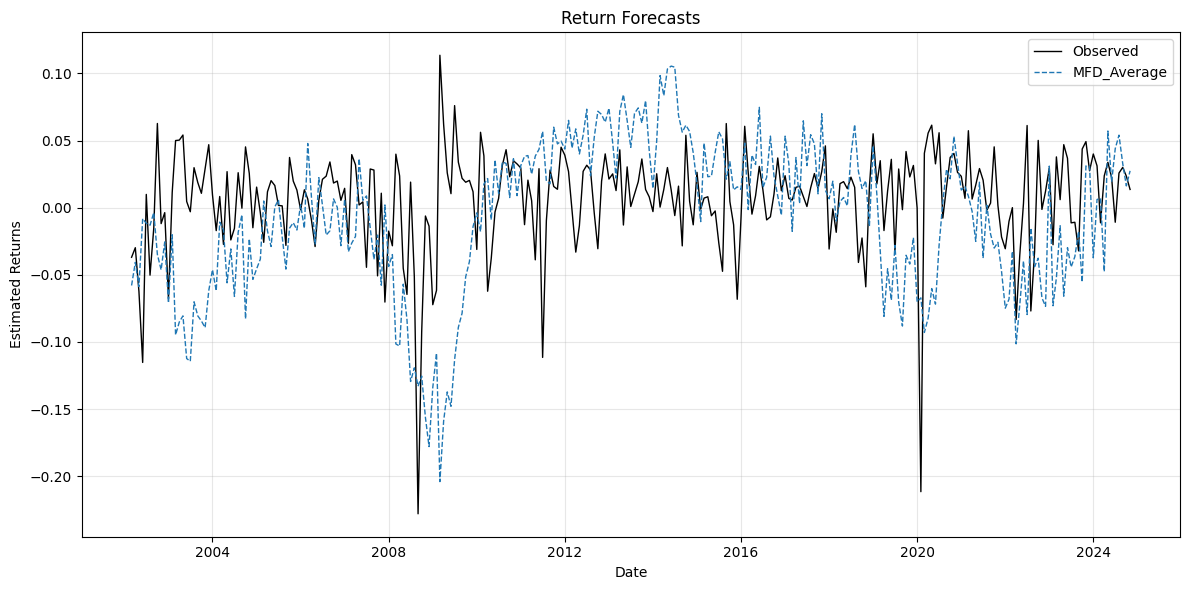

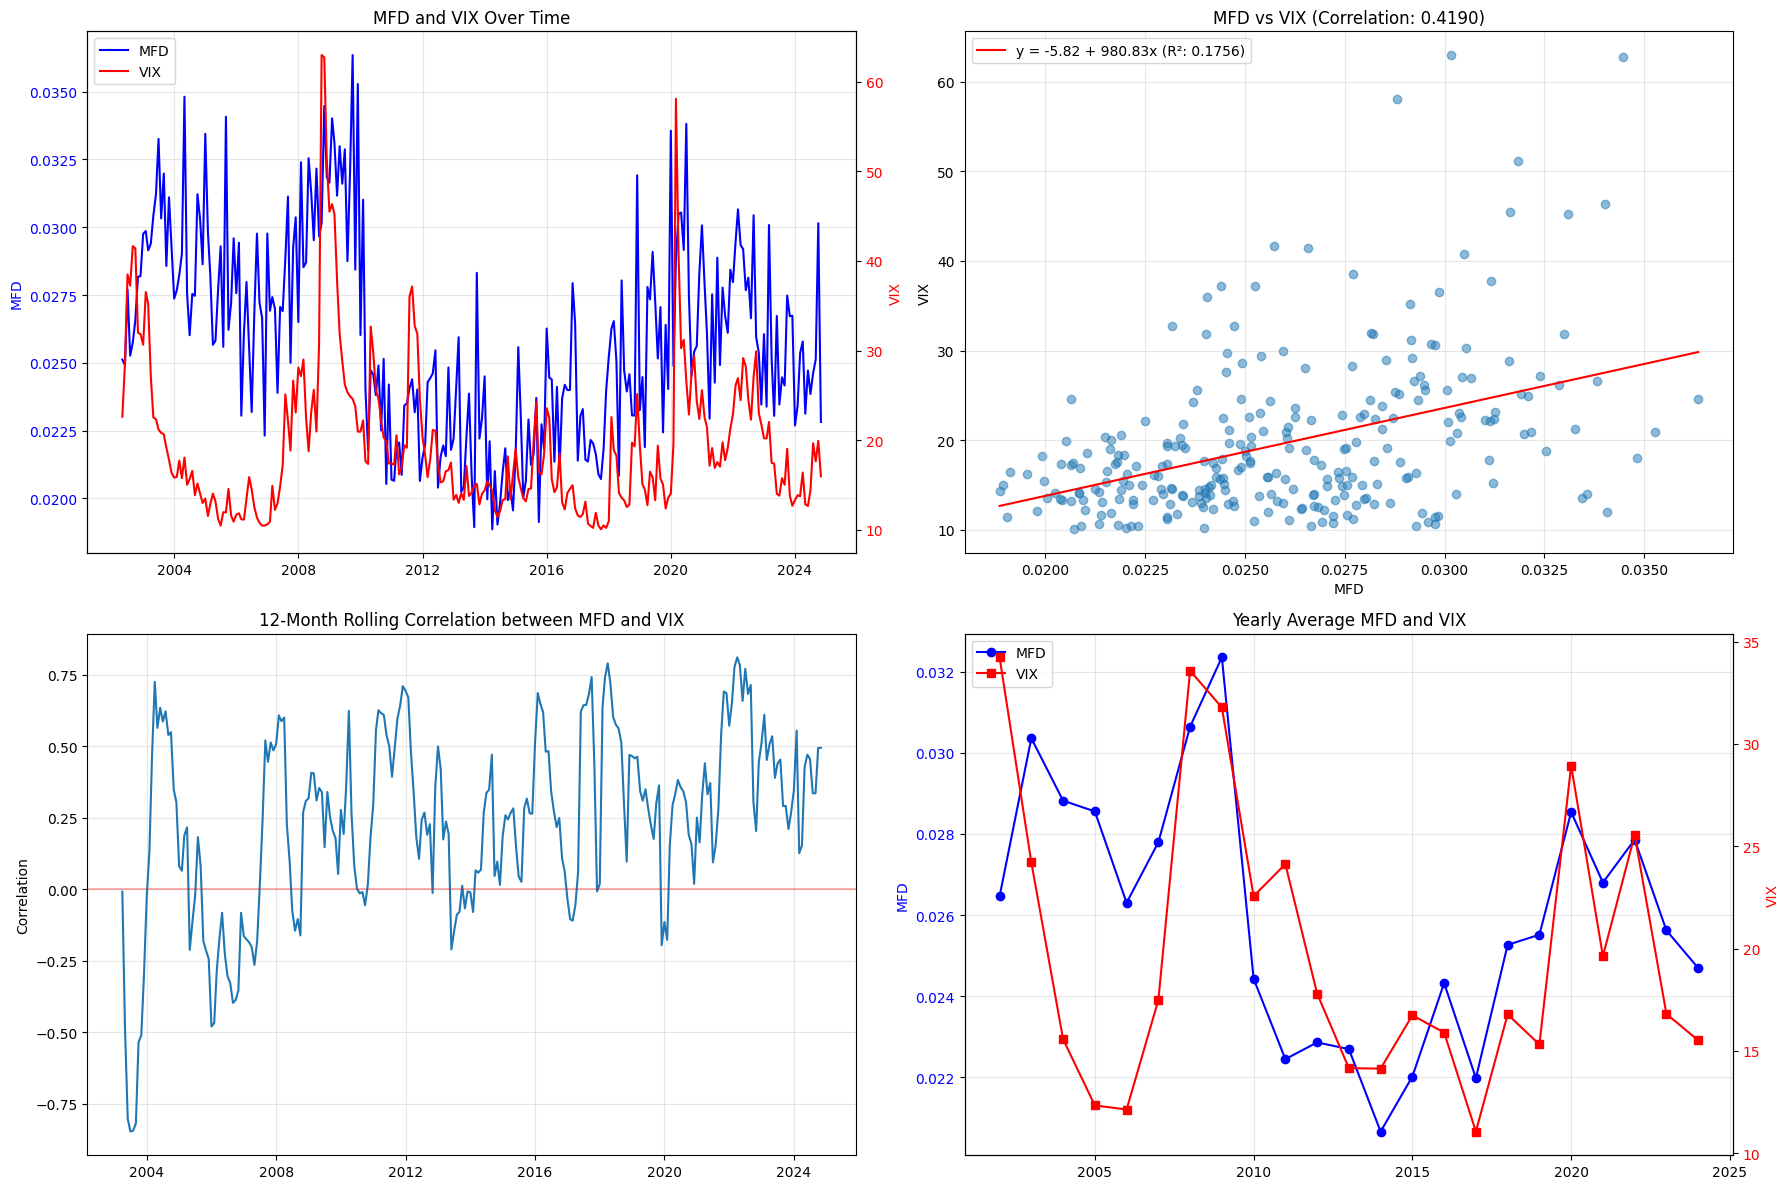


--- Data Coverage Analysis ---
MFD data period: 2002-04-01 00:00:00 to 2024-11-01 00:00:00
AAII data period: 1987-07-01 00:00:00 to 2025-05-01 00:00:00
Common period: 2002-04-01 00:00:00 to 2024-11-01 00:00:00
Number of common months: 272

--- Correlation Analysis ---
Correlation between MFD and AAII disagreement: 0.1730

--- Predictive Power Analysis ---
1. Mean Random Forest Forecast predicting returns:
   R-squared: 0.0095
   Coefficient: 0.0653 (t-stat: 1.6056, p-value: 0.1095)

2. AAII Sentiment predicting returns:
   R-squared: 0.0710
   Coefficient: 0.0822 (t-stat: 4.5437, p-value: 0.0000)

3. MFD Disagreement predicting returns:
   R-squared: 0.0006
   Coefficient: -0.2540 (t-stat: -0.4104, p-value: 0.6818)

4. AAII Disagreement predicting returns:
   R-squared: 0.0796
   Coefficient: -0.0313 (t-stat: -4.8316, p-value: 0.0000)

5. Horse race - Both forecast measures:
   R-squared: 0.0733
   RF Forecast coefficient: 0.0326 (t-stat: 0.8115, p-value: 0.4178)
   AAII Sentiment coe

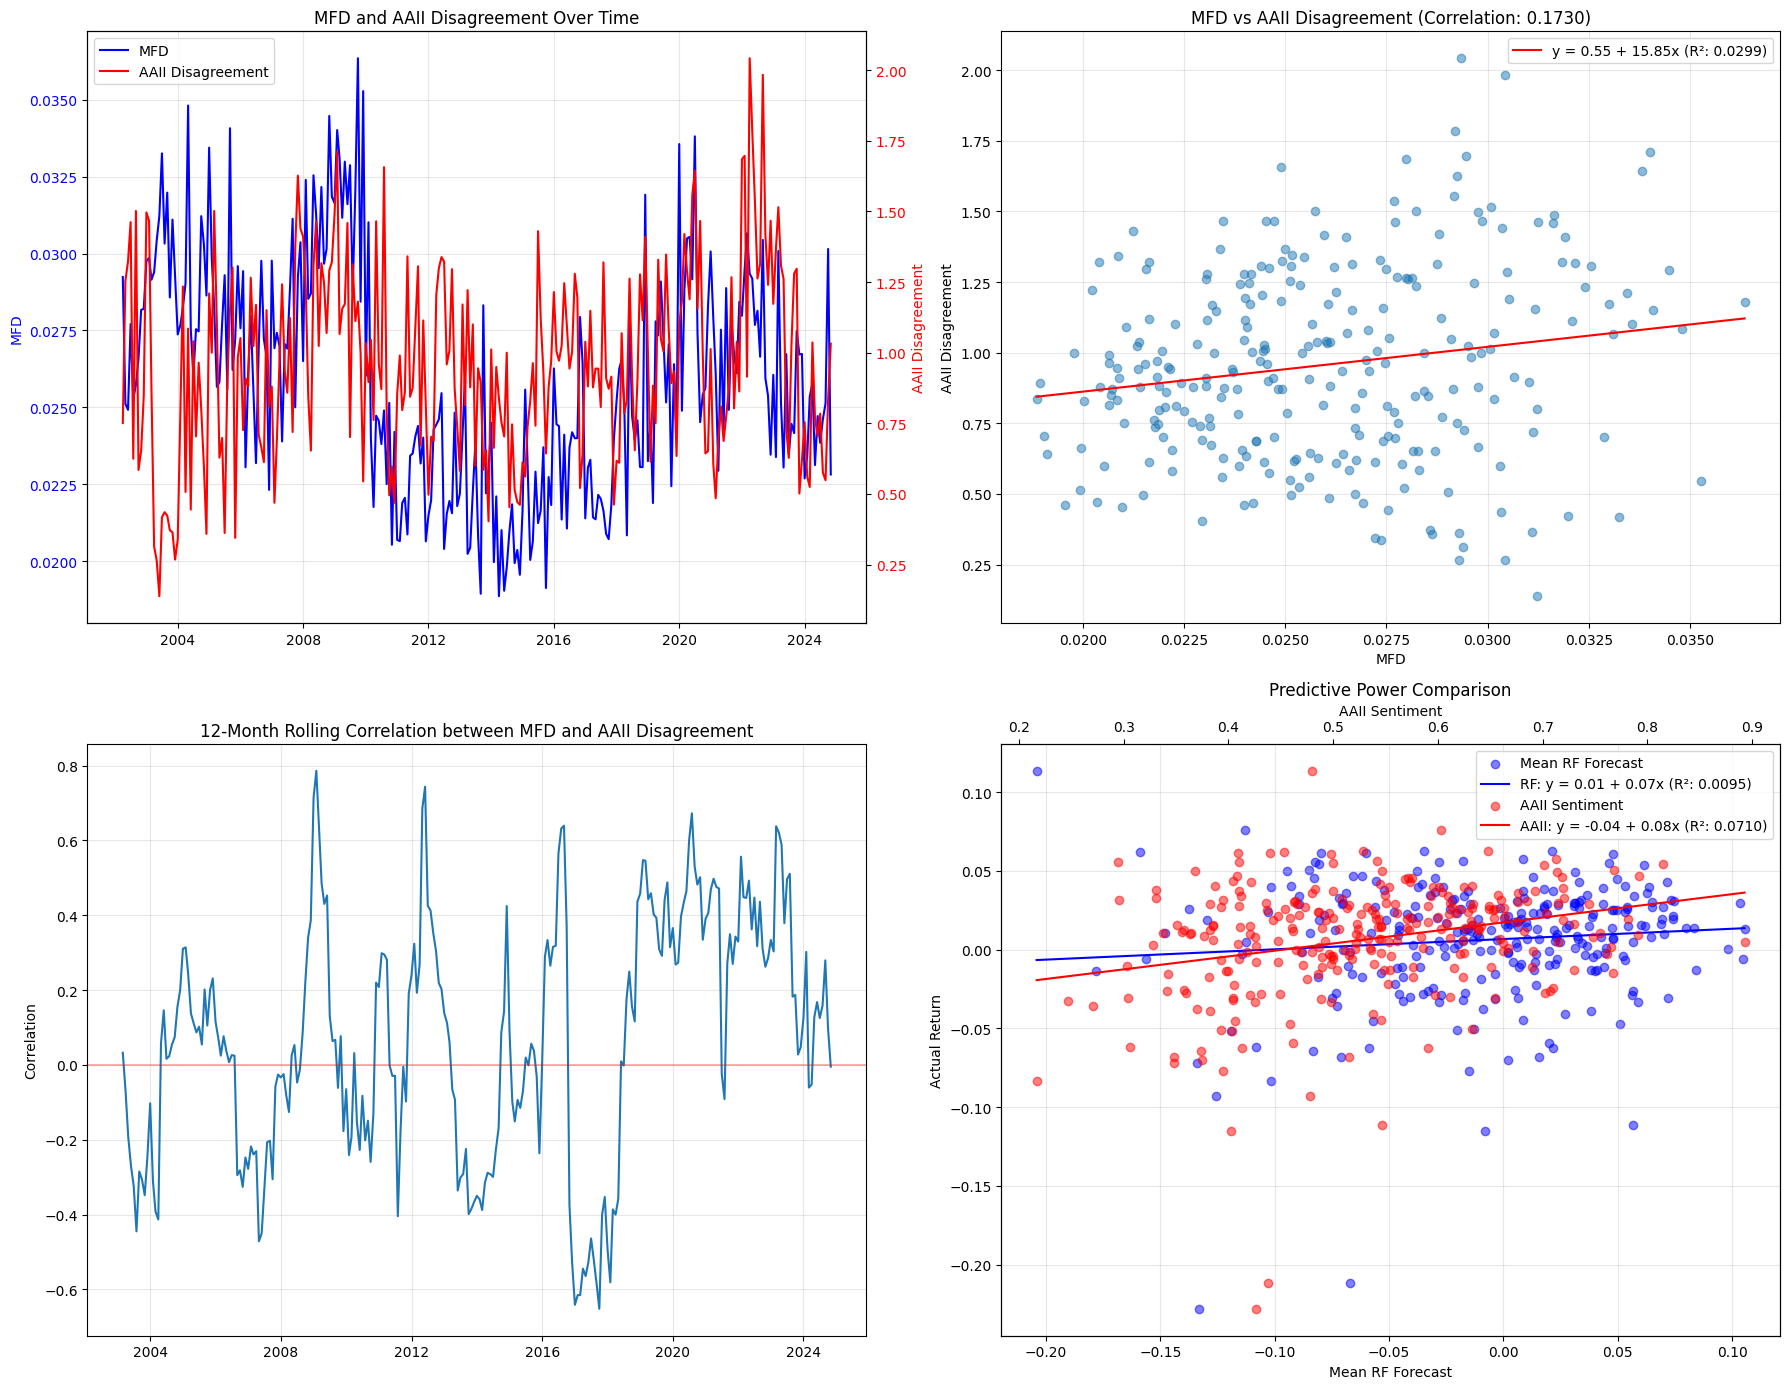


MFD Statistics (annualized):
Mean: 0.0900
Std Dev: 0.0129
Min: 0.0653
Max: 0.1259


In [32]:
mfd_values, mfd_analysis = main()